In [23]:
import pandas
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

Importamos el dataset limpio

In [24]:
clean_dataset = pandas.read_csv('bank-additional-clean.csv', sep=';')

Preparamos el dataset para implementar el modelo de machine learning

In [25]:
#Separamos el dataset en columnas X e Y (COMÚN)
x = clean_dataset.drop('y', axis=1)
y = clean_dataset['y']

#Normalizamos X porque vamos a entrenar con X a nuestro modelo (COMÚN)
norm = StandardScaler()
x_normalized = norm.fit_transform(x)

#Hacemos el split y obtenemos los parámetros de entrenamiento y testeo (COMÚN)
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.3, random_state=123)

Implementamos el modelo

In [26]:
knn = KNeighborsClassifier(metric='euclidean')
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)

Evaluamos el modelo

In [27]:
confmatrix = confusion_matrix(y_test, prediction)
confmatrix


array([[4598,  602],
       [ 874, 4367]], dtype=int64)

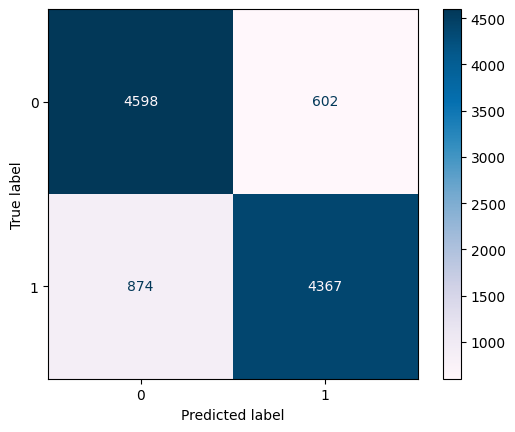

In [28]:
visual_confmatrix = ConfusionMatrixDisplay(confmatrix)
visual_confmatrix.plot(cmap='PuBu')

Evaluamos las métricas

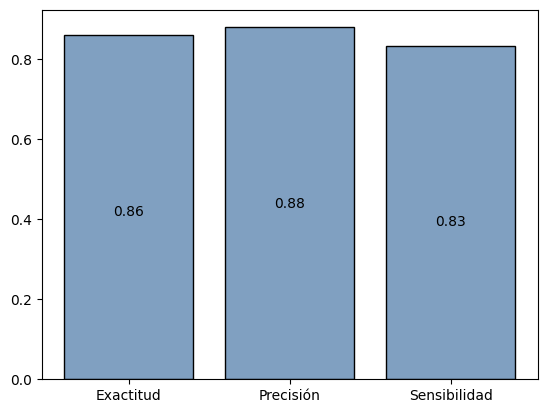

In [29]:
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)

metrics = {
  'Exactitud': [accuracy],
  'Precisión': [precision],
  'Sensibilidad': [recall]
}

df_metrics = pandas.DataFrame(metrics)
x1 = df_metrics.columns
y1 = df_metrics.iloc[0]
pyplot.bar(x1, y1, edgecolor='black', color='#80a0c1')
for index, metric in enumerate(x1):
  pyplot.text(float(index), float(df_metrics[metric].iloc[0]-0.45), f'{df_metrics[metric].iloc[0]:.2f}', ha='center')

conclusión: tuvimos buenos resultados tanto en precisión como en sensibilidad que serían en éste caso lo que es de nuestro interés. Sin embargo, vamos a aplicar métodos para evaluar estas métricas y ajustar de ser posible el entrenamiento.

## Cross Validation

In [30]:
from sklearn.model_selection import KFold, cross_val_score

In [31]:
kfolds = KFold(n_splits=5, shuffle=True)

Aplicamos el testeo de Cross Validation para los valores de precisión y sensibilidad

In [32]:
accuracy_crossval = cross_val_score(
  estimator=knn,
  X=x_train,
  y=y_train,
  scoring='accuracy',
  cv=kfolds
)
precision_crossval = cross_val_score(
  estimator=knn,
  X=x_train,
  y=y_train,
  scoring='precision',
  cv=kfolds
)
recall_crossval = cross_val_score(
  estimator=knn,
  X=x_train,
  y=y_train,
  scoring='recall',
  cv=kfolds
)

Graficamos los resultados obtenidos desde Cross Validation

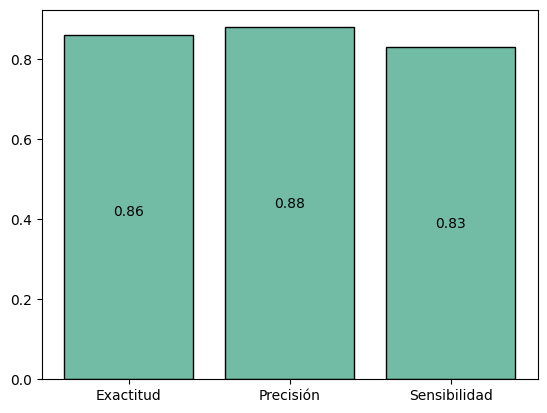

In [33]:
crossvalues = {
  'Exactitud': [round(accuracy_crossval.mean(), 2)],
  'Precisión': [round(precision_crossval.mean(), 2)],
  'Sensibilidad': [round(recall_crossval.mean(), 2)]
}

df_crossvalues = pandas.DataFrame(crossvalues)
x2 = df_crossvalues.columns
y2 = df_crossvalues.iloc[0]
ax2 = pyplot.bar(x2, y2, edgecolor='black', color='#72bca5')
for index, metric in enumerate(x2):
  pyplot.text(float(index), float(df_crossvalues[metric].iloc[0]-0.45), f'{df_crossvalues[metric].iloc[0]}', ha='center')

Comparamos ambos resultados 

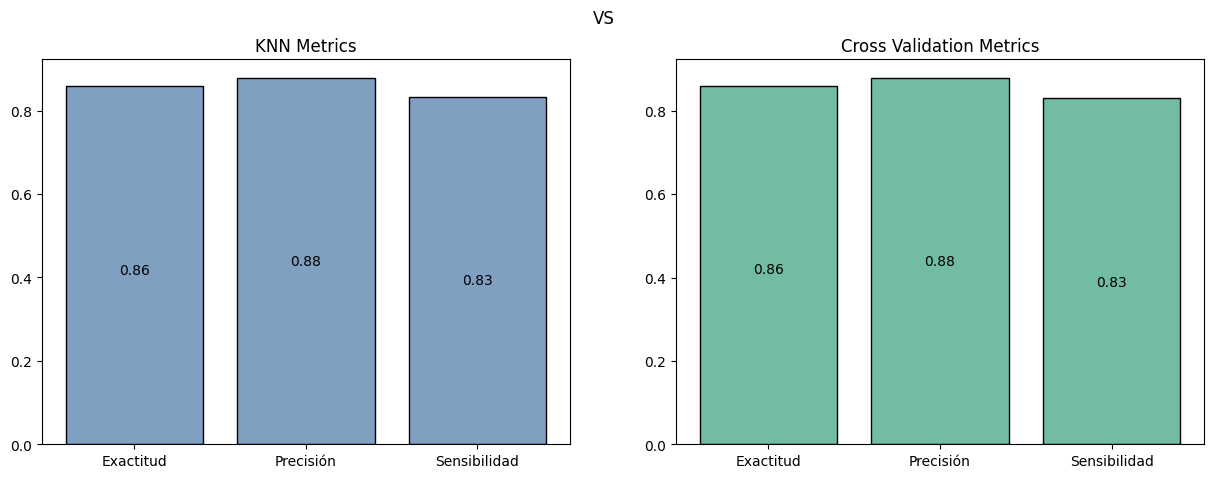

In [34]:
pyplot.figure(figsize=(15,5))
pyplot.suptitle('VS')
pyplot.subplot(121)
pyplot.title('KNN Metrics')
pyplot.bar(x1, y1, edgecolor='black', color='#80a0c1')
for index, metric in enumerate(x1):
  pyplot.text(float(index), float(df_metrics[metric].iloc[0]-0.45), f'{df_metrics[metric].iloc[0]:.2f}', ha='center')
pyplot.subplot(122)
pyplot.title('Cross Validation Metrics')
ax2 = pyplot.bar(x2, y2, edgecolor='black', color='#72bca5')
for index, metric in enumerate(x2):
  pyplot.text(float(index), float(df_crossvalues[metric].iloc[0]-0.45), f'{df_crossvalues[metric].iloc[0]}', ha='center')

Conclusión: tanto para las métricas del modelo entrenado como después de haber aplicado cross validation, efectivamente verificamos que nuestro modelo responde muy bien a distintas situaciones

## Optimización del modelo

In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [36]:
knn_params = {
  'n_neighbors': [4, 6, 8, 10], 
  'weights': ['uniform', 'distance'], 
  'algorithm': ['auto', 'ball_tree', 'kd_tree'], 
  'leaf_size': [15, 30, 45], 
  'p': [1, 2], #p1 = manhattan distance, p2 = ecludean distance
}
#'metric': ['minkowski', 'precomputed'] #Metrica para utilizar la distancia computada

In [37]:
randomsearch_knn = RandomizedSearchCV(
  knn,
  knn_params,
  n_iter=50,
  cv=kfolds,
  scoring='recall',
  n_jobs=-1
)

In [38]:
randomsearch_knn_fit = randomsearch_knn.fit(x_train, y_train)

In [39]:
df_random_results = pandas.DataFrame(randomsearch_knn_fit.cv_results_)
df_random_results.shape

(50, 18)

In [40]:
df_random_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_p,param_n_neighbors,param_leaf_size,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.388961,0.007725,22.955454,0.668659,distance,2,8,15,ball_tree,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.851945,0.842084,0.843170,0.854456,0.860418,0.850414,0.006937,1
1,0.459526,0.033955,23.056381,0.628980,distance,1,10,15,ball_tree,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.849854,0.846968,0.844820,0.852412,0.855915,0.849994,0.003920,13
2,0.313390,0.024253,20.860743,0.907400,uniform,2,6,45,ball_tree,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.804684,0.793244,0.794882,0.806623,0.804339,0.800754,0.005543,36
3,0.558565,0.039469,20.951088,0.219275,uniform,1,4,30,kd_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.792974,0.776964,0.789517,0.788226,0.800655,0.789667,0.007683,42
4,0.016190,0.003652,2.145479,0.107273,uniform,2,4,45,auto,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.792974,0.776964,0.789517,0.788226,0.800655,0.789667,0.007683,42


In [41]:
randomsearch_knn_fit.best_params_

{'weights': 'distance',
 'p': 2,
 'n_neighbors': 8,
 'leaf_size': 15,
 'algorithm': 'ball_tree'}

In [42]:
randomsearch_knn_fit.best_score_

0.8504144068087414